# Homework 4 Submission
## Yonadav Shavit

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.special import factorial
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

(Let's define some latex commands)
 
$\newcommand{\floor}[1]{\left \lfloor #1 \right \rfloor}$
$\newcommand{\clamp}[1]{\left [ #1 \right ]}$
$\newcommand{\lap}[1]{Lap\left ( #1 \right )}$
$\newcommand{\lapcdf}[2]{LapCDF\left ( #1, [-\inf, #2] \right )}$
$\newcommand{\lappdf}[2]{LapPDF\left ( #1, |_{#2} \right )}$
$\newcommand{\lapcdffull}[2]{\frac{1}{2} + \frac{1}{2}sgn\left({#2}\right)\left ( 1 - \exp{\left ( - \frac{|#2|}{#1} \right ) }\right )}$
$\newcommand{\lappdffull}[2]{\frac{1}{2 #1} \exp{\left ( - \frac{#2}{#1}\right ) }}$

## Problem 1

### (a)

We'll be implementing two different mechanisms, both of which rely on an estimation of $p_j$.

In the local DP case, we'll compute $I(x[j] = 0 \land y = 1)$, and then return that value (or its conjugate) with probability $\frac{e^\epsilon}{1 + e^\epsilon}$, and then scale that up by a factor of $c_\epsilon = \frac{e^\epsilon + 1}{e^\epsilon - 1}$.

In the centralized DP case, we'll compute $\frac{1}{n}\sum_{i = 0}^n{I(x_i[j] = 0 \land y_i = 1)}$, and then add Laplace noise of magnitude $\frac{1}{n\epsilon}$.

In [3]:
df = pd.read_csv("../data/hw4testdata.csv")

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.498210,0.50142,0.497110,0.498860,0.501840,0.500550,0.50161,0.499490,0.499700,0.501790,0.122850
std,0.499999,0.50000,0.499994,0.500001,0.499999,0.500002,0.50000,0.500002,0.500002,0.499999,0.328267
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.00000,0.000000,0.000000,1.000000,1.000000,1.00000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [ ]:
def local_pj(Xj, Y, epsilon, t):
    n = Xj.shape[0]
    eeps = e**epsilon
    correct_vals = Xj == Y
    randomize = np.random.binomial(1, eeps/(1+eeps), size=n).astype(bool)
    randomized_vals = np.logical_xor(randomize, correct_vals)
    c_e = (eeps + 1)/(eeps - 1)
    return c_e*randomized_vals.mean()

In [3]:
def lap_mechanism(epsilon, GS_q, size=None):
    return np.random.laplace(scale=GS_q/epsilon, size=size)

def dp_mean(x, epsilon, b, a=0):
    x_clipped = np.clip(x, a, b)
    GS_q = np.abs(b-a)/x.shape[0]
    return x_clipped.mean() + lap_mechanism(epsilon, GS_q)

def trimmed_mean(x, epsilon, D, upper=0.95, lower=0.05):
    n = x.shape[0]
    x_sorted = np.sort(x)
    x_trimmed = x_sorted[int(n*lower):int(n*upper)]
    GS_q = D/(0.9*n)
    return (1/((upper - lower)*n))*np.sum(x_trimmed) + lap_mechanism(epsilon, GS_q)

## (b)
The winsorized mean is not $\epsilon$-DP because the global sensitivity can, in certain cases, be much greater than $\frac{D}{n}$.

Say we have a dataset where the bottom 95.00...01% are $0$s and the top 4.99...% are $D$s (such that $P_{0.95} = 0$).
Now, we switch a single $0$ to $D$, and suddenly $P_{0.95} = D$. This means that the overall mean calculation changes by $\frac{D \times 0.05n}{n} = .05D$.
If $\frac{D}{n} = GS_q < .05D$, i.e. $n>20$, this violates $\epsilon$-DP.

## (c)
The utility function for the exponential mechanism for $p_t$ would be:
$$ u_t(x, y) = \min \{ \frac{100-t}{100} \left(\#\{ i: x_i \leq y\}\right), \frac{t}{100}\left(\#\{ i: x_i \geq y\}\right)\}$$

In [926]:
def pct_dp(x, t, epsilon):
    x = np.sort(x)
    n = x.shape[0]
    uniq_vals, uniq_poss = np.unique(x, return_index=True)
    n_uniq = uniq_vals.shape[0]
    if n_uniq == 1:
        return uniq_vals[0]
    u1 = np.zeros(n_uniq)
    u2 = np.zeros(n_uniq)
    w = np.zeros(n_uniq)
#     print(x)
    for i in range(n_uniq):
        lower = uniq_poss[i+1] - 1 if i != n_uniq - 1 else n # everything up to the next value
        upper = n - uniq_poss[i] # everything from the current value and up
        u1[i] = (100-t)/100*lower
        u2[i] = t/100*upper
        w[i] = ((uniq_poss[i+1] if i != n_uniq-1 else n) - uniq_poss[i])/n
    u = np.minimum(u1, u2)
    exp_u = np.exp(epsilon*u)
    p_raw = w*exp_u
    p = p_raw/np.sum(p_raw)
#     print(f"u:{u}\n exp_u:{exp_u}\n p_raw:{p_raw}\n p:{p}")
    return np.random.choice(uniq_vals, p=p)

## (d)

In [927]:
def trimmed_mean_dp_bounds(x, epsilon, b):
    n = x.shape[0]
    x = np.sort(x)
    p05 = pct_dp(x, 5, epsilon/3)
    p05_ind = np.argmax((x==p05))
    p95 = pct_dp(x, 95, epsilon/3)
    p95_ind = np.argmax(x==p95)
    x_trimmed = x[p05_ind:p95_ind+1]
    GS_q = (p95 - p05)/(0.9*n)
    return (1/(0.9*n))*np.sum(x_trimmed) + lap_mechanism(epsilon/3, GS_q)

In [986]:
x = np.random.random(size=1000)
epsilon = 1
print(pct_dp(x, 95, epsilon/3))
# print(trimmed_mean_dp_bounds(x, epsilon, 1))

0.7303791683714363


## (e)
This method actually seems to be differentially private, because a single input changing can no longer guaranteedly change the winsorization boundaries ($p_{.95}$ or $p_{.05}$).
If a single element cannot substantially change the boundaries, then by that same logic it should have little impact on the $\frac{n}{20}$ elements clamped to that value. Instead, its impact will primarily be felt as a single element change in the sum, which has bounded sensitivity $\frac{P_{95} - P_{05}}{n}$.


## (f)


In [878]:
df = pd.read_csv("../data/MaPUMS5full.csv")
df.describe()
puma_block_incomes = {puma_:df.income[df.puma == puma_].values for puma_ in df.puma.unique()}

In [879]:
D = 1e6
eps = 1
trials = 100
mean_types = ["normal", "trimmed", "true"]
mean_algs = {
    "true": lambda x, epsilon, b: np.mean(x),
    "normal": dp_mean,
    "trimmed": trimmed_mean_dp_bounds,
}
pumas = list(df.puma.unique())
puma_means = {t:{} for t in mean_types}
for puma_, puma_block in tqdm_notebook(puma_block_incomes.items()):
    x = np.sort(puma_block)
    for t in mean_types:
        ms = [mean_algs[t](x=x, epsilon=eps, b=D) for _ in range(trials)]
        puma_means[t][puma_] = ms

In [880]:
puma_by_mean = [(puma_means["true"][puma_][0], puma_) for puma_ in pumas]
pumas_sorted = [p[1] for p in sorted(puma_by_mean)]

In [881]:
results_df = pd.DataFrame(columns=['type_', 'puma_', 'mean'])
for type_ in ["normal", "trimmed", "true"]:
# for type_ in ["normal"]:
#     for puma_ in pumas_sorted:
    for i, puma_ in enumerate(pumas_sorted[:20]):
        results_df = results_df.append(
            pd.DataFrame(
                np.stack([np.array([type_]*trials),
                          np.array([i]*trials),
                          puma_means[type_][puma_]],
                         axis=-1
                        ),
                columns=['type_', 'puma_', 'mean']),
        ) 
results_df = results_df.astype({
    'type_': str,
    'puma_': int,
    'mean': float,
})

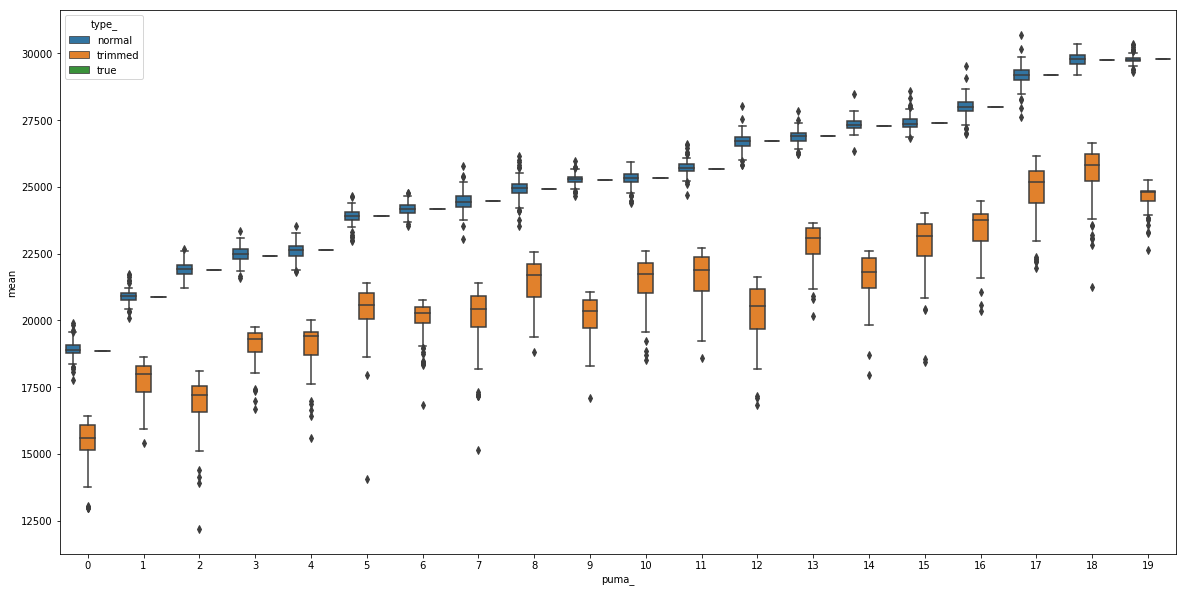

In [882]:
import seaborn as sns
fig = plt.figure(figsize=(20,10))
sns.boxplot(data=results_df,
            hue='type_', x='puma_', y='mean',
           )

In [49]:


def poisson_pdf(k):
    return 10**k*np.exp(-10)/factorial(k)

poisson_cdf_table = [poisson_pdf(0)] # seed it with the 0-th element
def poisson_cdf(k):
    k_computed = len(poisson_cdf_table) - 1
    if k <= k_computed:
        return poisson_cdf_table[k]
    else:
        sum_so_far = poisson_cdf_table[-1]
        for i in range(k_computed + 1, k + 1):
            pdf_i = poisson_pdf(i)
            sum_so_far += pdf_i
            poisson_cdf_table.append(sum_so_far)
        return sum_so_far

def poisson_inv_cdf(v):
    # value between 0 and 1, to be converted into a probability
    assert v <= 1 and v > 0
    while v > poisson_cdf_table[-1]:
        poisson_cdf(len(poisson_cdf_table) + 100) # calculate a hundred more elements
    else:
        for k, cdf_k in enumerate(poisson_cdf_table):
            if v < cdf_k:
                return k

def poisson_samples(n):
    samples = [poisson_inv_cdf(np.random.rand()) for i in range(n)]
    return np.asarray(samples)

### (b)

We'll implement the Laplace mechanism over a clamped range [a, b]

In [190]:
def lap_mechanism(epsilon, GS_q, size=None):
    return np.random.laplace(scale=GS_q/epsilon, size=size)

def dp_mean(x, epsilon, b, a=0):
    x_clipped = np.clip(x, a, b)
    GS_q = np.abs(b-a)/x.shape[0]
    return x_clipped.mean() + lap_mechanism(epsilon, GS_q)

### (c)

In [191]:
n = 200
eps = .5
b_range = range(10, 30)
trials = 100
estimation_errors = np.zeros(shape=len(b_range))
for trial in tqdm_notebook(range(trials)):
    x = poisson_samples(n)
    true_mean = x.mean()
    estimated_means = np.array([dp_mean(x, eps, b) for b in b_range])
    estimation_errors += (estimated_means - true_mean)**2
estimation_errors = estimation_errors/trials

Text(0.5, 1.0, 'MSE in reported mean as a function of clipping size b')

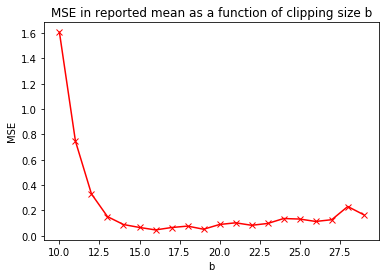

In [192]:
plt.plot(b_range, estimation_errors, 'r-x')
plt.xlabel("b")
plt.ylabel("MSE")
plt.title("MSE in reported mean as a function of clipping size b")

From our experiment, we can see that the optimal b value to minimize mean squared error $b^* = 17$ for this example.

### (d)

Individual values in the dataset may significantly affect our above procedure. If a particular value is an outlier, the smaller $b$ is, the more that value gets clipped. (In fact, the impact of the size of the clipping induced by $b$ is quadratic because we're looking at squared error.) So that value would influence the choice of $b$ across any bootstrap subset of the data in which it was included, and an adversary could use the fact that the final $b$ was higher than might have been otherwise expected from the rest of the population to extract that that individual was likely in the dataset.

### (e)

One alternative method is to simply use domain expertise about the likely range of values to set a reasonable $b$ (without looking at the data). So long as this is done independent of the practitioner's knowledge of the data itself, this is differentially private.

Alternatively, if we could compute a differentially private maximum (perhaps via an exponential mechanism), then we could set that as $b$. It might in practice be far from $b^*$, but it will still be narrower than "infinity". (Similarly, we could pick the 9/10ths largest value in a DP way using the exponential mechanism in more or less the same way that we find the median, but weighted.)

## Problem 3

### (a)

In [244]:
def regression(x, y):
    Sxy = np.sum((x-x.mean())*(y-y.mean()))
    Sxx = np.sum((x-x.mean())*(y-y.mean()))
    beta = Sxy/Sxx
    alpha = np.mean(y - beta*x)
    return alpha, beta
    
def dp_regression(x, y, eps, xmin, xmax, ymin, ymax, eps_beta_fraction=0.5):
    x = np.clip(x, xmin, xmax)
    y = np.clip(y, ymin, ymax)
    
    Sxy = np.sum((x-x.mean())*(y-y.mean()))
    Sxx = np.sum((x-x.mean())*(y-y.mean()))
    true_beta = Sxy/Sxx # TODO: remove
    # add Laplace noise
    corner_values = [xmin*ymin, xmin*ymax, xmax*ymin, xmax*ymax]
    GS_Sxy = max(corner_values) - min(corner_values)
    GS_Sxy = (ymax-ymin)*(xmax-xmin)
    GS_Sxx = (xmax-xmin)**2
    
    eps_beta = eps*eps_beta_fraction
    Sxy += lap_mechanism(eps_beta/2, GS_Sxy)
    Sxx += lap_mechanism(eps_beta/2, GS_Sxx)
    beta = Sxy/Sxx
    
    # now do DP mean release 
    eps_alpha = eps - eps_beta
    if beta > 0:
        a = ymin - xmin*beta
        b = ymax - xmax*beta
    else:
        a = ymax - xmax*beta
        b = ymin - xmin*beta
    alpha = dp_mean(y - beta*x, eps_alpha, a=a, b=b)
#     print("beta: {:0.2f}, true_beta: {:0.2f}, mean_miss: {:0.2f}, true_mean_miss: {:0.2f}".format(
#         beta,
#         true_beta,
#         np.mean(y-beta*x),
#         np.mean(y-true_beta*x)))
    
    return alpha, beta

def regression_samples(n, alpha=1, beta=1, sigma=1.):
    x = poisson_samples(n)
    y = beta*x + alpha + np.random.normal(scale=sigma, size=x.shape[0])
    return x, y

def regression_mse(x, y, alpha, beta):
    return np.mean((y - (alpha + beta*x))**2)

### (b)

In [249]:
trials = 100
n = 1000
eps = 1
# we'll pick our upper bound based on the likely range of values
# specifically, 99.9% of values fall within this range
# (we aren't using the specific individuals in our sample - 
# only known properties of the distribution)
xmax = poisson_inv_cdf(0.999)
# more arbitrarily, if we assume the magnitude of the slope is less than 10 from prior knowledge
guessed_max_slope = 10
ymin = -guessed_max_slope*xmax
ymax = guessed_max_slope*xmax

np_mses = []
dp_mses = []
for trial in tqdm_notebook(range(trials)):
    x, y = regression_samples(n)
    alpha_np, beta_np = regression(x, y)
    alpha_dp, beta_dp = dp_regression(x, y, eps, xmin=0, xmax=xmax, ymin=ymin, ymax=ymax)
    np_mses.append(regression_mse(x, y, alpha_np, beta_np))
    dp_mses.append(regression_mse(x, y, alpha_dp, beta_dp))

Text(0.5, 1.0, 'Example regression')

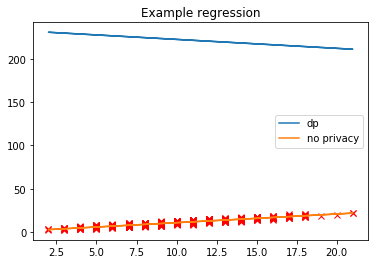

In [253]:
plt.plot(x, y, 'rx')
plt.plot(x, x*beta_dp + alpha_dp, label="dp")
plt.plot(x, x*beta_np + alpha_np, label="no privacy")
plt.legend()
plt.title("Example regression")

In [255]:
print("Average MSE across trials, with DP: {:0.2f}, w/o DP: {:0.2f}".format(np.mean(dp_mses), np.mean(np_mses)))

Average MSE across trials, with DP: 22364.53, w/o DP: 1.00


Clearly, DP substantially degrades utility.

Text(0, 0.5, 'frequency')

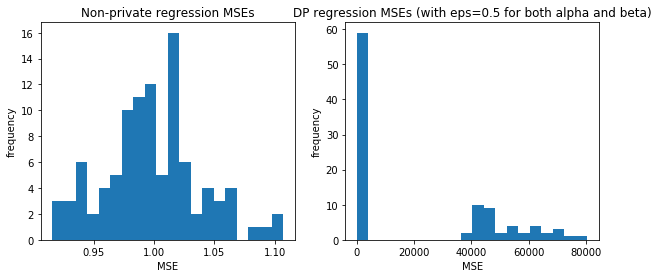

In [257]:
def ignore_outliers(z, max_dev=3.5):
    z = np.array(z)
    outlier_inds = np.abs(z - z.mean()) > np.std(z)*max_dev
    return z[np.logical_not(outlier_inds)]
    
bins = 20
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
plt.sca(axs[0])
plt.hist(ignore_outliers(np_mses), bins=bins);
plt.title("Non-private regression MSEs")
plt.xlabel("MSE")
plt.ylabel("frequency")
plt.sca(axs[1])
plt.hist(ignore_outliers(dp_mses), 
         histtype='barstacked',
         bins=bins);
plt.title("DP regression MSEs (with eps=0.5 for both alpha and beta)")
plt.xlabel("MSE")
plt.ylabel("frequency")

The distribution of residuals is much much higher when doing differentially private regression. After interrogating this for a while, the problem seems to be as follows:

When we spend an insufficient portion of our $\epsilon$ on estimating the slope, the estimate of the slope is off - which then makes the estimate of the intercept way, way off. Once the intercept is much larger or smaller than 1, almost every point will miss by that amount. This leads to enormous squared errors for nearly every point.


### (c)

Let's see whether we can't find a better allocation of epsilons.

In [273]:
trials = 200
eps_beta_fraction_range = np.linspace(.1, .9, 100)
avg_dp_mses = []
for eps_beta_fraction in tqdm_notebook(eps_beta_fraction_range):
    dp_mses = []
    for trial in range(trials):
        x, y = regression_samples(n)
        alpha_np, beta_np = regression(x, y)
        alpha_dp, beta_dp = dp_regression(x, y, eps, xmin=0, xmax=xmax, ymin=ymin, ymax=ymax,
                                          eps_beta_fraction=eps_beta_fraction)
        np_mses.append(regression_mse(x, y, alpha_np, beta_np))
        dp_mses.append(regression_mse(x, y, alpha_dp, beta_dp))
    avg_dp_mses.append(np.mean(dp_mses))

Best eps fraction: 0.86


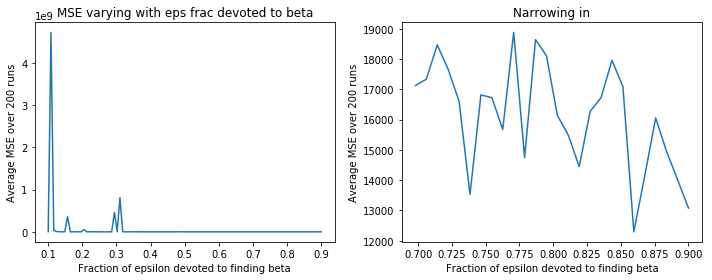

In [286]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(eps_beta_fraction_range, avg_dp_mses);
plt.title("MSE varying with eps frac devoted to beta")
plt.xlabel("Fraction of epsilon devoted to finding beta")
plt.ylabel("Average MSE over {} runs".format(trials))
best_eps_fraction = eps_beta_fraction_range[np.argmin(avg_dp_mses)]
plt.subplot(1, 2, 2)
range_top = np.argmin(avg_dp_mses) + 20
range_bottom = np.argmin(avg_dp_mses) - 20
plt.plot(eps_beta_fraction_range[range_bottom:range_top],
         avg_dp_mses[range_bottom:range_top]);
plt.title("Narrowing in")
plt.xlabel("Fraction of epsilon devoted to finding beta")
plt.ylabel("Average MSE over {} runs".format(trials))
plt.tight_layout()
print("Best eps fraction: {:0.2f}".format(best_eps_fraction))

As we expected we can see that it's much better to devote more of the epsilon to finding an accurate slope (optimally around $0.85$) - 
with the idea being that any error in the slope quickly translates to a greater error in the intercept.
Hence, we want to allocate epsilon to minimize this double-counting of error.

One sidenote: even the optimized version of this performs very, very poorly, and that's even after assuming that our slopes exist in a fairly narrow range ($\pm 10$).

## Problem 4.

Let's write out the problem.
$$ E[\#\{ i \in [n] : A(M(X))_i = X_i\}/n]$$
$$ = \frac{1}{n} \sum_{i=1}^n E[A(M(X))_i == X_i] $$
by linearity of expectation. Let's focus on a single such example $i$.

Let $X^{(i)}$ be the dataset identical to $X$, except that row $i$ is replaced with value $0$. Obviously, all such datasets are neighbors of $X$ (or the same as $X$), and so DP properties should hold (if they're the same, the ineqality holds because the equality holds).

Assume that, for a set of outputs $s \in S$, if $M(X) = s$ our adversary guesses that $A(s)_i = X_i$.
$$ E[A(M(X))_i == X_i] = P(M(X) \in S) \leq e^\epsilon P(M(X^{(i)} \in S) + \delta$$
$$P(M(X^{(i)}) \in S) = E[A(M(X^{(i)})) = X^{(i)}_i] = 1-p$$
because there's only a $1-p$ probability that $X_i$ happened to be 0.

Thus, we have that
$$ E[\#\{ i \in [n] : A(M(X))_i = X_i\}/n]$$
$$ = \frac{1}{n} \sum_{i=1}^n E[A(M(X))_i == X_i] $$
$$ \leq \frac{1}{n} \sum_{i=1}^n \left ( e^\epsilon (1-p) + \delta \right ) $$
$$ = e^\epsilon (1-p) + \delta $$
This seems to complete one half of the desired $\max{\left \{ p, 1-p\right \}}$, but repeating this procedure twice would suggest the bound is the min of these two bounds - which suggests to me that I've erred somewhere in this derivation.
But I'm not sure where, and have run out of time :(

## Problem 5
Emailed separately.